In [1]:
pwd

'/Users/kellymclean/2021_Jan_31_Imbalanced_Classification_with_the_Fraudulent_Credit_Card_Transactions_Dataset'

In [9]:
# load and summarize the dataset
from pandas import read_csv
from collections import Counter
# define the dataset location
filename = '/Users/kellymclean/2021_Jan_31_Imbalanced_Classification_with_the_Fraudulent_Credit_Card_Transactions_Dataset/creditcard.csv'
# load the csv file as a data frame
dataframe = read_csv(filename, header=None)
# summarize the shape of the dataset
print(dataframe.shape)
# summarize the class distribution
target = dataframe.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print((k, v, per))

(284807, 31)
(0.0, 284315, 99.82725143693798)
(1.0, 492, 0.1727485630620034)


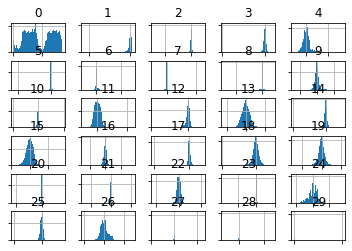

In [10]:
# create histograms of input variables
from pandas import read_csv
from matplotlib import pyplot
# define the dataset location
filename = '/Users/kellymclean/2021_Jan_31_Imbalanced_Classification_with_the_Fraudulent_Credit_Card_Transactions_Dataset/creditcard.csv'
# load the csv file as a data frame
df = read_csv(filename, header=None)
# drop the target variable
df = df.drop(30, axis=1)
# create a histogram plot of each numeric variable
ax = df.hist(bins=100)
# disable axis labels to avoid the clutter
for axis in ax.flatten():
	axis.set_xticklabels([])
	axis.set_yticklabels([])
# show the plot
pyplot.show()

In [11]:
# summarize the amount variable
from pandas import read_csv
# define the dataset location
filename = 'creditcard.csv'
# load the csv file as a data frame
df = read_csv(filename, header=None)
# summarize the amount variable.
print(df[29].describe())

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: 29, dtype: float64


Model Test and Baseline Result

We will evaluate candidate models using repeated stratified k-fold cross-validation.

The k-fold cross-validation procedure provides a good general estimate of model performance that is not too optimistically biased, at least compared to a single train-test split. We will use k=10, meaning each fold will contain about 284807/10 or 28,480 examples.

Stratified means that each fold will contain the same mixture of examples by class, that is about 99.8 percent to 0.2 percent normal and fraudulent transaction respectively. Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model. We will use 3 repeats.

This means a single model will be fit and evaluated 10 * 3 or 30 times and the mean and standard deviation of these runs will be reported.

This can be achieved using the RepeatedStratifiedKFold scikit-learn class.

We will use the recommended metric of area under precision-recall curve or PR AUC.

This requires that a given algorithm first predict a probability or probability-like measure. The predicted probabilities are then evaluated using precision and recall at a range of different thresholds for mapping probability to class labels, and the area under the curve of these thresholds is reported as the performance of the model.

This metric focuses on the positive class, which is desirable for such a severe class imbalance. It also allows the operator of a final model to choose a threshold for mapping probabilities to class labels (fraud or non-fraud transactions) that best balances the precision and recall of the final model.

We can define a function to load the dataset and split the columns into input and output variables. The load_dataset() function below implements this.

In [12]:
# test harness and baseline model evaluation for the credit dataset
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	data = read_csv(full_path, header=None)
	# retrieve numpy array
	data = data.values
	# split into input and output elements
	X, y = data[:, :-1], data[:, -1]
	return X, y

# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
	# calculate precision-recall curve
	p, r, _ = precision_recall_curve(y_true, probas_pred)
	# calculate area under curve
	return auc(r, p)

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation the metric
	metric = make_scorer(pr_auc, needs_proba=True)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

# define the location of the dataset
full_path = 'creditcard.csv'
# load the dataset
X, y = load_dataset(full_path)
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean PR AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

(284807, 30) (284807,) Counter({0.0: 284315, 1.0: 492})
Mean PR AUC: 0.501 (0.000)


Evaluate Models

In this section, we will evaluate a suite of different techniques on the dataset using the test harness developed in the previous section.

The goal is to both demonstrate how to work through the problem systematically and to demonstrate the capability of some techniques designed for imbalanced classification problems.

The reported performance is good but not highly optimized (e.g. hyperparameters are not tuned).

Can you do better? If you can achieve better PR AUC performance using the same test harness, I’d love to hear about it. Let me know in the comments below.

Evaluate Machine Learning Algorithms

Let’s start by evaluating a mixture of machine learning models on the dataset.

It can be a good idea to spot check a suite of different nonlinear algorithms on a dataset to quickly flush out what works well and deserves further attention and what doesn’t.

We will evaluate the following machine learning models on the credit card fraud dataset:

Decision Tree (CART)
k-Nearest Neighbors (KNN)
Bagged Decision Trees (BAG)
Random Forest (RF)
Extra Trees (ET)
We will use mostly default model hyperparameters, with the exception of the number of trees in the ensemble algorithms, which we will set to a reasonable default of 100. We will also standardize the input variables prior to providing them as input to the KNN algorithm.

We will define each model in turn and add them to a list so that we can evaluate them sequentially. The get_models() function below defines the list of models for evaluation, as well as a list of model short names for plotting the results later.

In [ ]:
# spot check machine learning algorithms on the credit card fraud dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	data = read_csv(full_path, header=None)
	# retrieve numpy array
	data = data.values
	# split into input and output elements
	X, y = data[:, :-1], data[:, -1]
	return X, y

# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
	# calculate precision-recall curve
	p, r, _ = precision_recall_curve(y_true, probas_pred)
	# calculate area under curve
	return auc(r, p)

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation the metric
	metric = make_scorer(pr_auc, needs_proba=True)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

# define models to test
def get_models():
	models, names = list(), list()
	# CART
	models.append(DecisionTreeClassifier())
	names.append('CART')
	# KNN
	steps = [('s',StandardScaler()),('m',KNeighborsClassifier())]
	models.append(Pipeline(steps=steps))
	names.append('KNN')
	# Bagging
	models.append(BaggingClassifier(n_estimators=100))
	names.append('BAG')
	# RF
	models.append(RandomForestClassifier(n_estimators=100))
	names.append('RF')
	# ET
	models.append(ExtraTreesClassifier(n_estimators=100))
	names.append('ET')
	return models, names

# define the location of the dataset
full_path = 'creditcard.csv'
# load the dataset
X, y = load_dataset(full_path)
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
	# evaluate the model and store results
	scores = evaluate_model(X, y, models[i])
	results.append(scores)
	# summarize performance
	print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>CART 0.758 (0.040)


Make Prediction on New Data

In this section, we can fit a final model and use it to make predictions on single rows of data.

We will use the KNN model as our final model that achieved a PR AUC of about 0.867. Fitting the final model involves defining a Pipeline to scale the numerical variables prior to fitting the model.

The Pipeline can then be used to make predictions on new data directly and will automatically scale new data using the same operations as performed on the training dataset.

First, we can define the model as a pipeline.

In [ ]:
# fit a model and make predictions for the on the credit card fraud dataset
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	data = read_csv(full_path, header=None)
	# retrieve numpy array
	data = data.values
	# split into input and output elements
	X, y = data[:, :-1], data[:, -1]
	return X, y

# define the location of the dataset
full_path = 'creditcard.csv'
# load the dataset
X, y = load_dataset(full_path)
# define model to evaluate
model = KNeighborsClassifier()
# scale, then fit model
pipeline = Pipeline(steps=[('s',StandardScaler()), ('m',model)])
# fit the model
pipeline.fit(X, y)
# evaluate on some normal cases (known class 0)
print('Normal cases:')
data = [[0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62],
	[0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.183361270123994,-0.145783041325259,-0.0690831352230203,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69],
	[1,-1.35835406159823,-1.34016307473609,1.77320934263119,0.379779593034328,-0.503198133318193,1.80049938079263,0.791460956450422,0.247675786588991,-1.51465432260583,0.207642865216696,0.624501459424895,0.066083685268831,0.717292731410831,-0.165945922763554,2.34586494901581,-2.89008319444231,1.10996937869599,-0.121359313195888,-2.26185709530414,0.524979725224404,0.247998153469754,0.771679401917229,0.909412262347719,-0.689280956490685,-0.327641833735251,-0.139096571514147,-0.0553527940384261,-0.0597518405929204,378.66]]
for row in data:
	# make prediction
	yhat = pipeline.predict_proba([row])
	# get the probability for the positive class
	result = yhat[0][1]
	# summarize
	print('>Predicted=%.3f (expected 0)' % (result))
# evaluate on some fraud cases (known class 1)
print('Fraud cases:')
data = [[406,-2.3122265423263,1.95199201064158,-1.60985073229769,3.9979055875468,-0.522187864667764,-1.42654531920595,-2.53738730624579,1.39165724829804,-2.77008927719433,-2.77227214465915,3.20203320709635,-2.89990738849473,-0.595221881324605,-4.28925378244217,0.389724120274487,-1.14074717980657,-2.83005567450437,-0.0168224681808257,0.416955705037907,0.126910559061474,0.517232370861764,-0.0350493686052974,-0.465211076182388,0.320198198514526,0.0445191674731724,0.177839798284401,0.261145002567677,-0.143275874698919,0],
	[7519,1.23423504613468,3.0197404207034,-4.30459688479665,4.73279513041887,3.62420083055386,-1.35774566315358,1.71344498787235,-0.496358487073991,-1.28285782036322,-2.44746925511151,2.10134386504854,-4.6096283906446,1.46437762476188,-6.07933719308005,-0.339237372732577,2.58185095378146,6.73938438478335,3.04249317830411,-2.72185312222835,0.00906083639534526,-0.37906830709218,-0.704181032215427,-0.656804756348389,-1.63265295692929,1.48890144838237,0.566797273468934,-0.0100162234965625,0.146792734916988,1],
	[7526,0.00843036489558254,4.13783683497998,-6.24069657194744,6.6757321631344,0.768307024571449,-3.35305954788994,-1.63173467271809,0.15461244822474,-2.79589246446281,-6.18789062970647,5.66439470857116,-9.85448482287037,-0.306166658250084,-10.6911962118171,-0.638498192673322,-2.04197379107768,-1.12905587703585,0.116452521226364,-1.93466573889727,0.488378221134715,0.36451420978479,-0.608057133838703,-0.539527941820093,0.128939982991813,1.48848121006868,0.50796267782385,0.735821636119662,0.513573740679437,1]]
for row in data:
	# make prediction
	yhat = pipeline.predict_proba([row])
	# get the probability for the positive class
	result = yhat[0][1]
	# summarize
	print('>Predicted=%.3f (expected 1)' % (result))